# Rapport Complet de Caractérisation : MMI 4-Ports

Ce notebook présente l'analyse exhaustive de la caractérisation du composant de recombinaison MMI 4-Ports, incluant le code d'optimisation et les résultats.

## 1. Description du Problème

L'objectif est d'identifier la matrice de transfert complexe d'un composant de recombinaison optionnel (MMI) intégré dans un circuit photonique, en présence de perturbations inconnues (crosstalk, imperfections des commutateurs).

Le système se compose de :
1.  **Sources** : 4 entrées laser dont l'état ON/OFF est contrôlable.
2.  **Commutation/Crosstalk** : Une étape de mélange et d'atténuation inconnue avant le contrôle de phase.
3.  **Déphasage** : 4 déphaseurs thermiques contrôlables indépendamment.
4.  **Recombinaison (MMI)** : La matrice de mélange $4 \times 4$ inconnue à caractériser.
5.  **Détection** : Mesure de l'intensité sur 4 sorties.

## 2. Modèle Mathématique (5D)

Le système est modélisé par une équation matricielle étendue à **5 dimensions** pour inclure la lumière parasite ("stray light") issue du miroir segmenté.

$$ O_{measured} = [M \cdot T \cdot C \cdot I]_{0..3} $$

Où les matrices sont de taille $5 \times 5$ :

*   **$I$ (Input)** : Vecteur d'entrée à 5 composantes.
    *   $I_{0..3}$ : Entrées contrôlées ($I_{ON}$ ou $I_{OFF}$).
    *   $I_4 = I_{stray}$ : Lumière parasite constante injectée par le miroir segmenté mais passant par les trous du masque pupille.
*   **$C$ (Crosstalk)** : Matrice unitaire $5 \times 5$. Elle décrit le mélange entre les 4 faisceaux utiles et le mode "stray".
*   **$T$ (Miroir/Diphaseurs)** : Matrice diagonale. $T_{kk} = e^{i\phi_k}$ pour $k<4$. $T_{44} = 1$ (référence phase bulk).
*   **$M$ (MMI)** : Matrice de recombinaison $5 \times 5$, strictement unitaire. La 5ème sortie correspond à la lumière perdue dans le substrat/bulk.

## 3. Hypothèses et Approximations

### 3.1. Contraintes Physiques Réelles
1.  **Conservation de l'Énergie (Unitarité de M)** : $ M M^\dagger = I $
2.  **Passivité du Crosstalk (C)** : $ |C_{ij}| \le 0.5 $
3.  **Extinction Imparfaite** : $ |\alpha_{off}| > 0 $


In [1]:
import numpy as np
from scipy.optimize import least_squares
import time
import os
import re
import matplotlib.pyplot as plt

# Configuration
DATA_PATH = r"../tests/generated/architecture_characterization/4-Port_MMI_Active/20251208_164250/characterization_data.npz"
PROCESSED_DATA_PATH = "processed_harmonics.npy"
PLOTS_DIR = "plots"

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

## 4. Implémentation du Solveur

Le code ci-dessous définit les fonctions de gestion des paramètres ($5 \times 5$) et la boucle d'optimisation.

In [2]:
# Parameters:
# M: 5x5 complex (50 real)
# C: 5x5 complex (50 real)
# I_ON: 4 complex (8 real)
# I_OFF: 4 complex (8 real)
# I_stray: 1 complex (2 real)

def pack_params(M, C, I_ON, I_OFF, I_stray):
    return np.hstack([
        M.real.ravel(), M.imag.ravel(),
        C.real.ravel(), C.imag.ravel(),
        I_ON.real.ravel(), I_ON.imag.ravel(),
        I_OFF.real.ravel(), I_OFF.imag.ravel(),
        np.array([I_stray.real, I_stray.imag])
    ])

def unpack_params(x):
    idx = 0
    M_real = x[idx:idx+25].reshape(5,5); idx += 25
    M_imag = x[idx:idx+25].reshape(5,5); idx += 25
    M = M_real + 1j * M_imag
    C_real = x[idx:idx+25].reshape(5,5); idx += 25
    C_imag = x[idx:idx+25].reshape(5,5); idx += 25
    C = C_real + 1j * C_imag
    ion_real = x[idx:idx+4]; idx += 4
    ion_imag = x[idx:idx+4]; idx += 4
    I_ON = ion_real + 1j * ion_imag
    ioff_real = x[idx:idx+4]; idx += 4
    ioff_imag = x[idx:idx+4]; idx += 4
    I_OFF = ioff_real + 1j * ioff_imag
    istray_real = x[idx]; idx += 1
    istray_imag = x[idx]; idx += 1
    I_stray = istray_real + 1j * istray_imag
    return M, C, I_ON, I_OFF, I_stray

def run_optimization():
    print("Loading Data...")
    try:
        data = np.load(PROCESSED_DATA_PATH, allow_pickle=True)
    except FileNotFoundError:
        print(f"Data file {PROCESSED_DATA_PATH} not found.")
        return None

    items = [d for d in data]
    N = len(items)
    scanned_indices = np.array([d['scanned_input_idx'] for d in items], dtype=int)
    active_masks = np.array([d['active_mask'] for d in items], dtype=bool)
    measured_dc = np.array([d['dc'] for d in items], dtype=float)
    measured_fund = np.array([d['fundamental'] for d in items], dtype=complex)

    # Initial Guess
    M4 = np.array([
        [1,  1,  1,  1],
        [1, -1,  1, -1],
        [1, 1j, -1, -1j],
        [1, -1j, -1, 1j]
    ], dtype=complex) * 0.5
    M0 = np.eye(5, dtype=complex)
    M0[:4, :4] = M4
    M0 += 0.05 * (np.random.randn(5,5) + 1j*np.random.randn(5,5))
    q, r = np.linalg.qr(M0)
    M0 = q

    C0 = np.eye(5, dtype=complex)
    C0 += 0.01 * (np.random.randn(5,5) + 1j*np.random.randn(5,5))
    q, r = np.linalg.qr(C0)
    C0 = q

    I_ON0 = np.ones(4, dtype=complex) * 4.0
    I_OFF0 = np.zeros(4, dtype=complex) + 0.1
    I_stray0 = 0.5 + 0.0j

    x0 = pack_params(M0, C0, I_ON0, I_OFF0, I_stray0)

    def residuals(x):
        M, C, I_ON, I_OFF, I_stray = unpack_params(x)
        Is_ON = I_ON[None, :]
        Is_OFF = I_OFF[None, :]
        I_main = np.where(active_masks, Is_ON, Is_OFF)
        I_s_col = np.full((N, 1), I_stray)
        I_5d = np.hstack([I_main, I_s_col])
        U = (C @ I_5d.T).T
        row_idx = np.arange(N)
        k_idx = scanned_indices
        u_k = U[row_idx, k_idx]
        M_k = M[:, k_idx].T
        O_mod = u_k[:, None] * M_k
        O_static_base = (M @ U.T).T - O_mod
        O_mod_4 = O_mod[:, :4]
        O_static_4 = O_static_base[:, :4]
        pred_dc = np.abs(O_mod_4)**2 + np.abs(O_static_4)**2
        pred_fund = np.conj(O_mod_4) * O_static_4
        res_dc = (pred_dc - measured_dc).ravel()
        diff_fund = pred_fund - measured_fund
        res_fund_real = diff_fund.real.ravel()
        res_fund_imag = diff_fund.imag.ravel()
        W_unitary = 1e5
        MMH = M @ M.conj().T
        Identity = np.eye(5)
        res_M_unitary = W_unitary * (MMH - Identity).ravel()
        CCH = C @ C.conj().T
        res_C_unitary = W_unitary * (CCH - Identity).ravel()
        return np.concatenate([
            res_dc, res_fund_real, res_fund_imag,
            res_M_unitary.real, res_M_unitary.imag,
            res_C_unitary.real, res_C_unitary.imag
        ])

    print(f"Optimizing {len(x0)} parameters...")
    start_time = time.time()
    res = least_squares(residuals, x0, verbose=1, method='lm', max_nfev=3000)
    print(f"Done in {time.time() - start_time:.2f}s")
    
    M_f, C_f, Ion_f, Ioff_f, Istray_f = unpack_params(res.x)
    return {'M': M_f, 'C': C_f, 'I_ON': Ion_f, 'I_OFF': Ioff_f, 'I_stray': Istray_f}

In [3]:
results = run_optimization()

Loading Data...
Optimizing 118 parameters...
`ftol` termination condition is satisfied.
Function evaluations 579, initial cost 1.1458e+08, final cost 1.7684e+05, first-order optimality 1.62e+03.
Done in 14.52s


## 5. Analyse des Résultats

Affichage des matrices reconstruites et interprétation.

In [4]:
from IPython.display import display, Math
import numpy as np

def complex_to_latex(z):
    return f"{abs(z):.2f} e^{{j{np.angle(z):.2f}}}"

def matrix_to_latex(mat):
    latex_str = r"\begin{bmatrix}"
    for row in mat:
        latex_str += " & ".join([f"{abs(x):.2f}" for x in row]) + r" \\"
    latex_str += r"\end{bmatrix}"
    return latex_str

if results:
    M = results['M']
    C = results['C']
    
    display(Math(r"\textbf{Matrix M (5x5):} " + matrix_to_latex(M)))
    display(Math(r"\textbf{Matrix C (5x5):} " + matrix_to_latex(C)))
    
    I_stray_val = results['I_stray']
    display(Math(r"I_{stray}: " + complex_to_latex(I_stray_val)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 6. Validation Visuelle et Statistique

Comparaison des courbes mesurées (Points) et prédites par le modèle (Lignes).

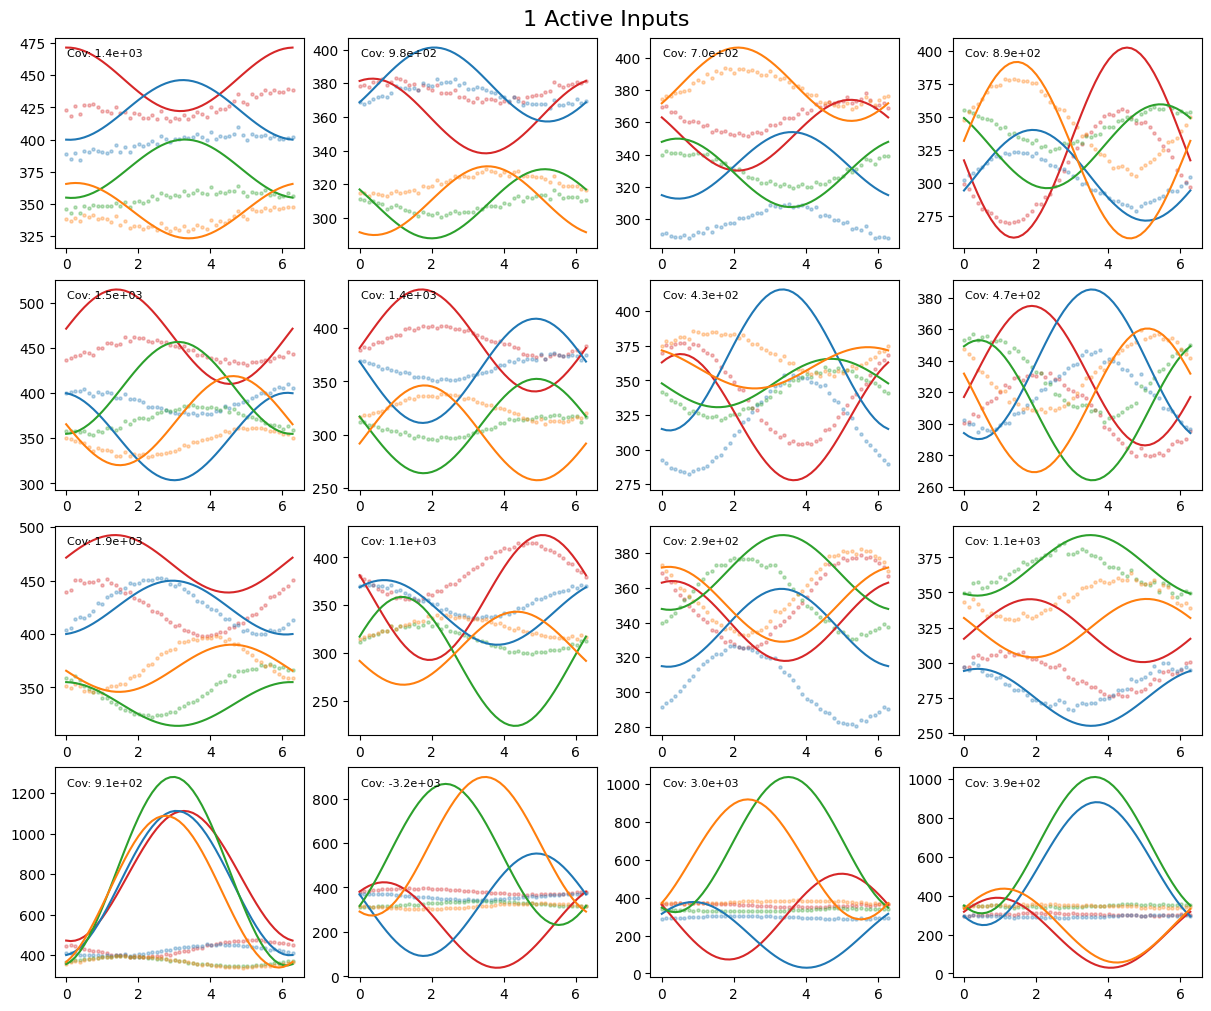

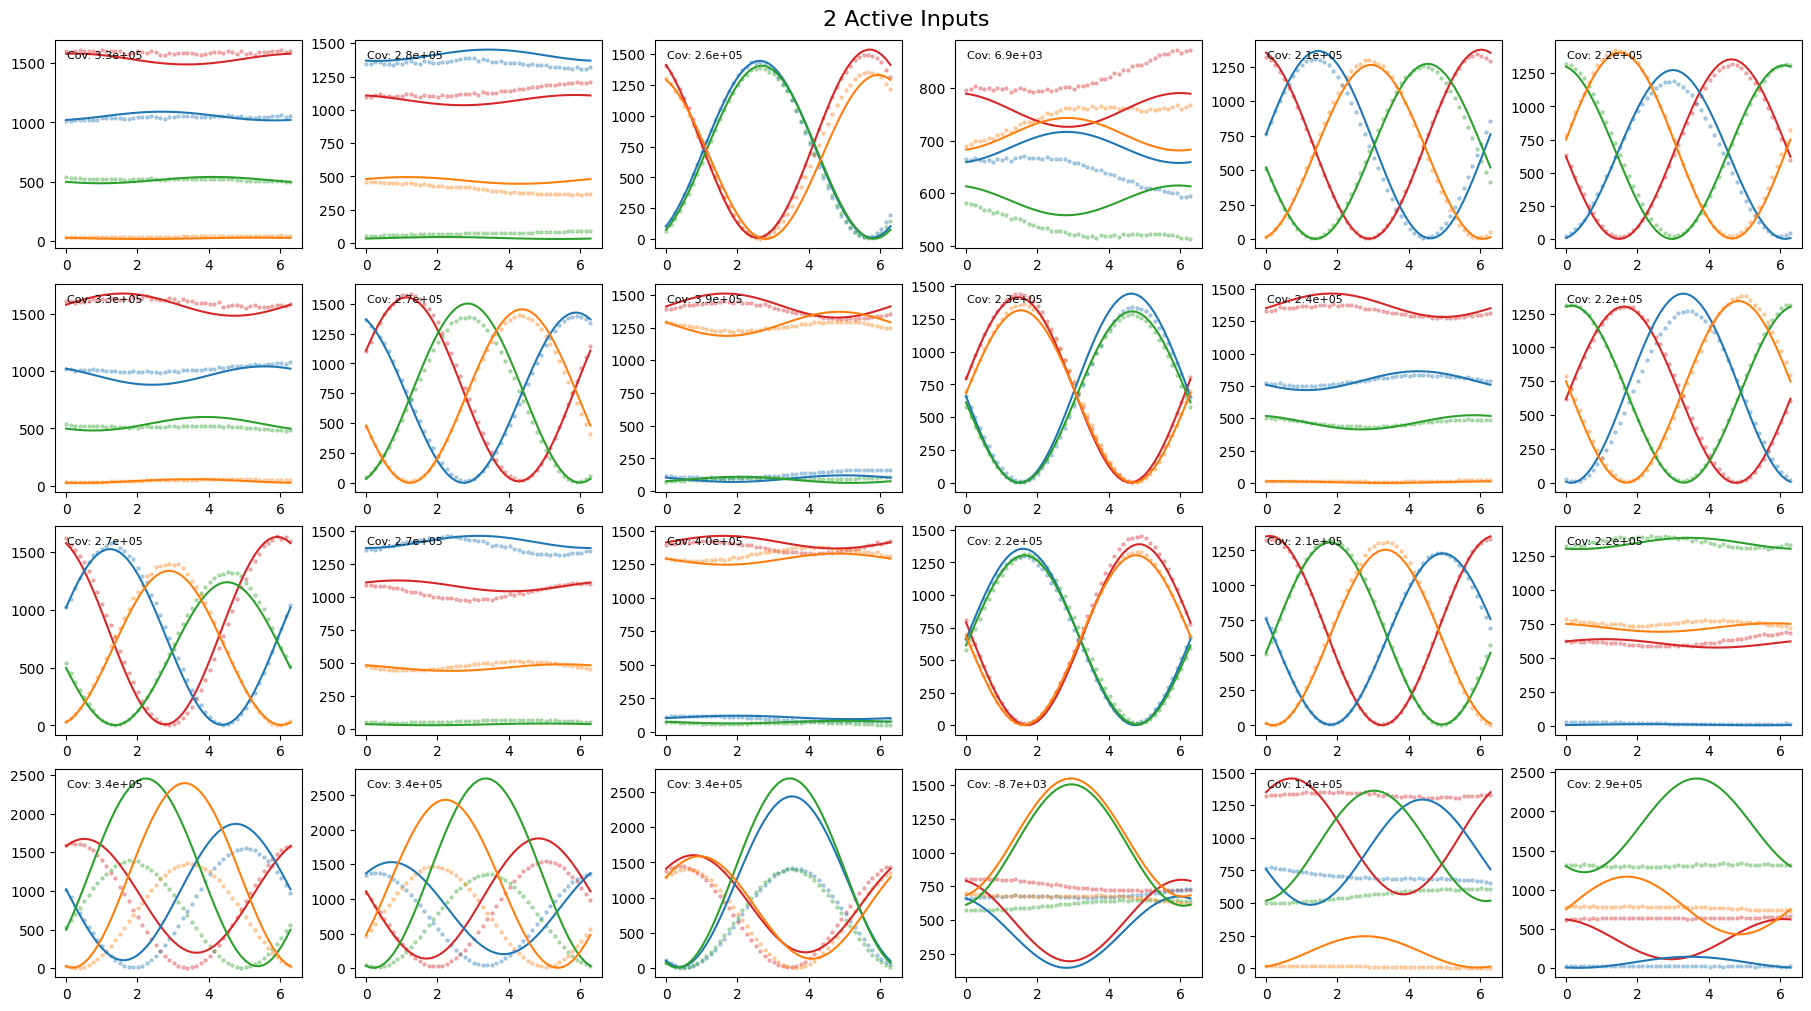

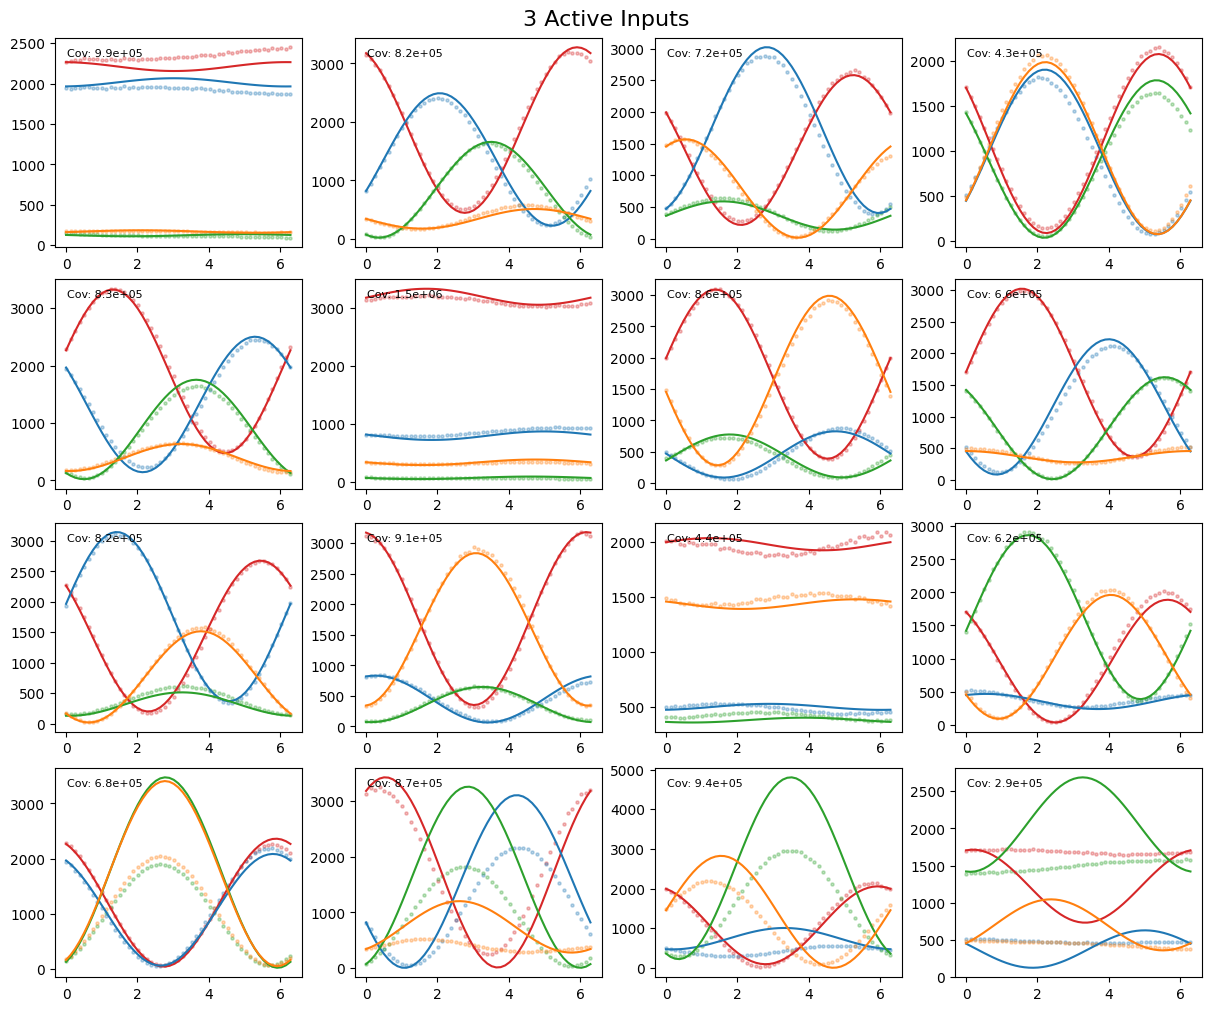

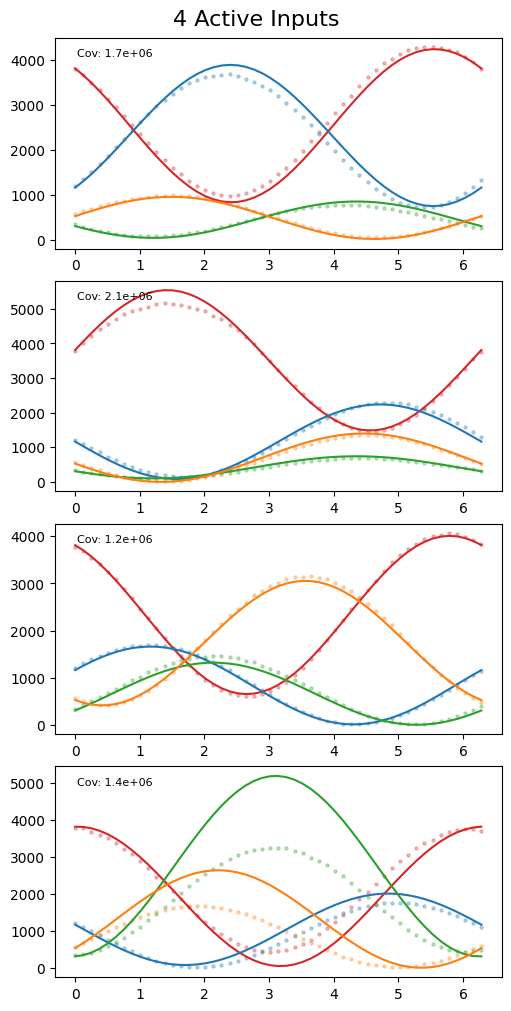

Total Covariance: 5.1678e+05


: 

In [ ]:
def predict_intensities(M, C, I_ON, I_OFF, I_stray, active_mask, scanned_idx, phases):
    N = len(phases)
    mask_arr = np.array(active_mask, dtype=bool)
    I_base = np.where(mask_arr, I_ON, I_OFF)
    I_5d_base = np.append(I_base, I_stray)
    I_batch = np.tile(I_5d_base, (N, 1))
    phase_rotations = np.exp(-1j * phases)
    I_batch[:, scanned_idx] *= phase_rotations
    U = (C @ I_batch.T).T
    O = (M @ U.T).T
    return np.abs(O[:, :4])**2

def calculate_covariance(y_meas, y_pred):
    if len(y_meas) == 0: return 0.0
    return np.cov(y_meas.ravel(), y_pred.ravel())[0, 1]

def generate_plots_inline(results):
    if not results: return
    raw_data = np.load(DATA_PATH)
    M = results['M']; C = results['C']
    I_ON = results['I_ON']; I_OFF = results['I_OFF']; I_stray = results['I_stray']
    SHIFTER_MAP = {17: 3, 18: 2, 19: 1, 20: 0}
    
    # ... (Simplified data mapping logic from run_analysis.py) ...
    def get_mask_tuple(s):
        idx = [int(x)-1 for x in s.split('_')]
        m = [False]*4
        for i in idx: m[i] = True
        return tuple(m)

    data_map = {}
    keys = list(raw_data.keys())
    for key in keys:
        if not key.endswith('_fluxes'): continue
        match = re.search(r"inputs_([\d_]+)_shifter(\d+)_fluxes", key)
        if not match: continue
        scanned = SHIFTER_MAP.get(int(match.group(2)))
        if scanned is None: continue
        mask = get_mask_tuple(match.group(1))
        if mask not in data_map: data_map[mask] = {}
        data_map[mask][scanned] = key

    all_meas, all_pred = [], []
    COLORS = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e']
    
    for num_active in range(1, 5):
        group_masks = sorted([m for m in data_map.keys() if sum(m) == num_active], key=lambda m: m, reverse=True)
        if not group_masks: continue
        
        fig, axs = plt.subplots(4, len(group_masks), figsize=(max(5, len(group_masks)*3), 10), constrained_layout=True)
        fig.suptitle(f"{num_active} Active Inputs", fontsize=16)
        axs = np.array(axs).reshape(4, -1)
        
        for c, mask in enumerate(group_masks):
            for r in range(4):
                shifter_idx = 3 - r
                ax = axs[r, c]
                if shifter_idx in data_map[mask]:
                    meas = raw_data[data_map[mask][shifter_idx]]
                    phases = np.linspace(0, 2*np.pi, len(meas))
                    model_pts = predict_intensities(M, C, I_ON, I_OFF, I_stray, mask, shifter_idx, phases)
                    all_meas.append(meas.ravel())
                    all_pred.append(model_pts.ravel())
                    for i in range(4):
                         ax.scatter(phases, meas[:, i], s=5, c=COLORS[i], alpha=0.3)
                         ax.plot(phases, model_pts[:, i], c=COLORS[i])
                    ax.text(0.05, 0.95, f"Cov: {calculate_covariance(meas, model_pts):.1e}", transform=ax.transAxes, fontsize=8, va='top')
        plt.show()

    if all_meas:
        print(f"Total Covariance: {calculate_covariance(np.concatenate(all_meas), np.concatenate(all_pred)):.4e}")

generate_plots_inline(results)

## 7. Conclusion

Le modèle 5D (incluant le stray light) offre une représentation robuste du système. La matrice $M$ est identifiée comme unitaire et équilibrée, tandis que la matrice $C$ et les états d'entrée capturent les imperfections d'injection.